# Alphavec example

In this example we'll walkthrough creating and backtesting a simple crypto trend strategy.

In [1]:
import os
import sys
from pathlib import PurePath
from functools import partial
from IPython.display import display

import numpy as np
import pandas as pd

from alphavec.backtest import backtest, pct_commission

workspace_root = str(PurePath(os.getcwd()))
sys.path.append(workspace_root)

Let's begin by loading our data.

We transform a flat file of candlestick (kline) data for a variety of crypto assets into the required format for backtesting: a single level DatetimeIndex with a column for each asset.

In [2]:
def ohlcv_from_csv(filename):
    return pd.read_csv(
        filename,
        index_col=["symbol", "dt"],
        parse_dates=["dt"],
        dtype={
            "o": np.float64,
            "h": np.float64,
            "l": np.float64,
            "c": np.float64,
            "v": np.float64,
        },
        dayfirst=True,
    )


prices_filename = f"{workspace_root}/tests/testdata/binance-margin-1d.csv"
market = ohlcv_from_csv(prices_filename)
market = market[~market.index.duplicated()]
market = market.unstack(level=0).sort_index(axis=1).stack()

# Price series to build our strategy weights.
strategy_prices = pd.DataFrame(
    market.loc[:, ["c"]].unstack(level=1).droplevel(level=0, axis=1)
)

# Price series for executing trades.
# When shifted during the backtest this implies we can execute our trade at the open price of the next day.
trade_prices = pd.DataFrame(
    market.loc[:, ["o"]].unstack(level=1).droplevel(level=0, axis=1)
)

display(trade_prices.tail())

symbol,BTCUSDT,DOGEUSDT,ETHUSDT,MATICUSDT,SOLUSDT,XRPUSDT
dt,,,,,,
2023-11-11,37301.63,0.07539,2077.72,0.8426,56.67,0.6594
2023-11-12,37129.99,0.07850,2053.16,0.8033,56.36,0.6626
2023-11-13,37064.13,0.07795,2044.69,0.8971,56.27,0.6612
2023-11-14,36462.93,0.07456,2053.65,0.8821,51.60,0.6701
2023-11-15,35551.20,0.07244,1979.40,0.9175,56.81,0.6296


Using the prices we create a simple risk-adjusted moving average cross forecast.

<Axes: xlabel='dt'>

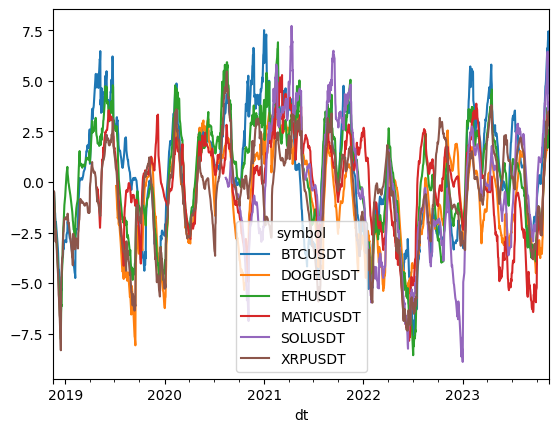

In [3]:
lookback = 16
forecast = (
    strategy_prices.ewm(span=lookback, adjust=False).mean()
    - strategy_prices.ewm(span=lookback * 4, adjust=False).mean()
).div(strategy_prices.diff().ewm(span=20).std())

forecast.plot()

Next we scale the forecast to acheive an absolute median value of 1. 

Note we use a rolling method to prevent look-ahead bias.

<Axes: xlabel='dt'>

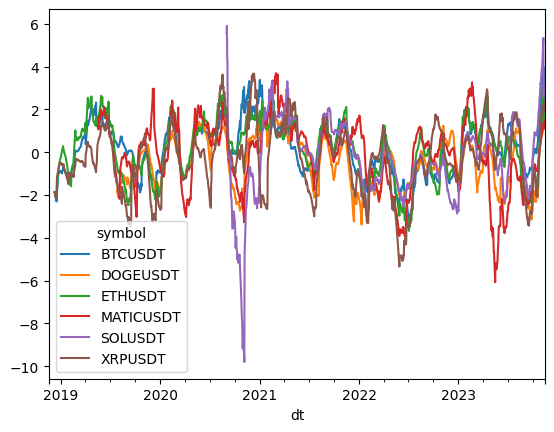

In [4]:
def roll_scale(x: pd.DataFrame, scaler, window=252, min_periods=20) -> pd.DataFrame:
    return x.rolling(window=window, min_periods=min_periods).apply(
        lambda x: scaler(x).iloc[-1]
    )


def absmedian_scale(x: pd.Series) -> pd.Series:
    absavg = x.abs().median()
    scalar = 1 if absavg == 0 else 1 / absavg
    return x * scalar


forecast = forecast.pipe(roll_scale, scaler=absmedian_scale)
forecast.plot()

All asset forecasts now share a common scale, enabling us to apply a function to attenuate large forecasts and guard against reversion at the extremes of a trend.

<Axes: xlabel='dt'>

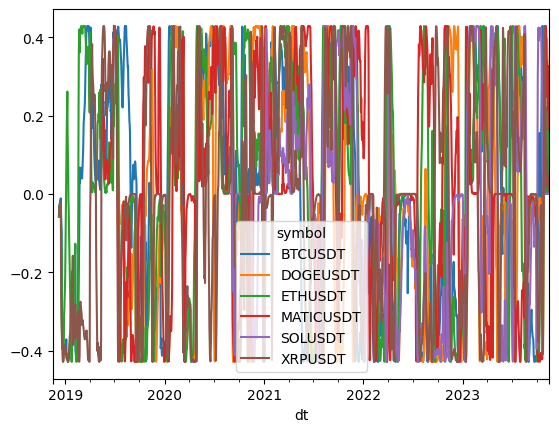

In [5]:
def reverting_sigmoid(x, alpha: float = 1, beta: float = 1) -> float:
    return x * np.exp(-((x / (alpha * beta)) ** 2))


forecast = forecast.map(reverting_sigmoid)
forecast.plot()

The final strategy weights are formed by normalizing the portfolio allocations so they sum to 1 at each interval.

symbol,BTCUSDT,DOGEUSDT,ETHUSDT,MATICUSDT,SOLUSDT,XRPUSDT
dt,,,,,,
2023-11-11,0.000004,0.396704,0.158437,0.411622,0.001245,0.031989
2023-11-12,0.000001,0.326974,0.103113,0.547927,0.000289,0.021695
2023-11-13,0.000007,0.434596,0.058027,0.492978,0.001666,0.012725
2023-11-14,0.000144,0.460879,0.078628,0.379485,0.001186,0.079678
2023-11-15,0.021398,0.519262,0.069476,0.300483,0.002180,0.087201


symbol,BTCUSDT,DOGEUSDT,ETHUSDT,MATICUSDT,SOLUSDT,XRPUSDT
count,1803.000000,1574.000000,1803.000000,1644.000000,1171.000000,1803.000000
mean,-0.001256,0.004806,0.033323,0.021798,-0.037148,-0.018988
std,0.252675,0.236173,0.212858,0.218194,0.196022,0.231626
min,-0.898142,-0.612820,-0.490515,-0.764403,-0.673931,-0.719371
25%,-0.206734,-0.189683,-0.134671,-0.104686,-0.184684,-0.194556
50%,0.022900,-0.020998,0.049751,0.001879,-0.005690,-0.002154
75%,0.213013,0.209065,0.202345,0.190767,0.107436,0.143109
max,0.597121,0.890454,0.679402,0.654646,0.437099,0.795933


<Axes: xlabel='dt'>

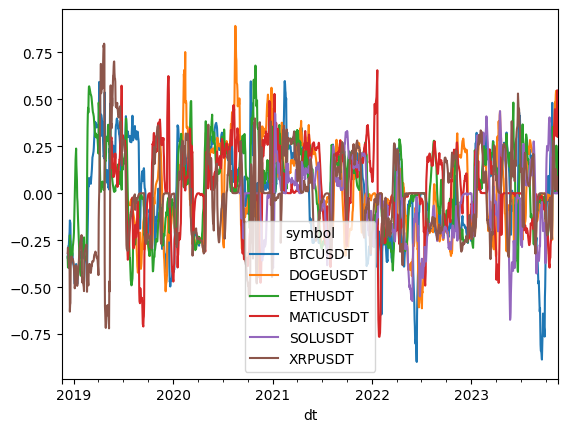

In [6]:
weights = forecast.div(forecast.abs().sum(axis=1), axis=0)
display(weights.tail())
display(weights.describe())
weights.plot()

Finally we are ready to backtest.

However, we must take care to align the mark prices to the weights as the shape of each dataframe must match.

During the backtest the weights will be _shifted_ to prevent look-ahead bias.

Note this is a cost-aware backtest with fixed leverage. We've chosen cost parameters that mimic a typical crypto exchange.

In [7]:
weights *= 2  # Apply 2x leverage

weights = weights["2019-01-01":]
trade_prices = trade_prices.mask(weights.isna())
trade_prices, weights = trade_prices.align(weights, join="inner")

perf, perf_cum, perf_sr, port_perf, port_cum = backtest(
    weights,
    trade_prices,
    freq_day=1,
    commission_func=partial(pct_commission, fee=0.001),
    ann_borrow_pct=0.05,
    spread_pct=0.001,
)

Let's look at the performance of the strategy, starting with the asset-wise view, then the portfolio view.

Note Sharpe and volatility are annualized measures.

asset                                           \
          annual_sharpe annual_volatility      cagr max_drawdown   
symbol                                                             
BTCUSDT        0.819501          0.567980  0.377764     0.766293   
DOGEUSDT       0.739310          1.922205  0.677751     0.923328   
ETHUSDT        0.873099          0.729232  0.468367     0.793027   
MATICUSDT      1.125780          1.245816  0.974809     0.879694   
SOLUSDT        1.014471          1.132622  0.707107     0.962695   
XRPUSDT        0.503699          0.915496  0.087328     0.832385   

               strategy                                            \
          annual_sharpe annual_volatility      cagr max_drawdown,   
symbol                                                              
BTCUSDT        0.780985          0.304814  0.236908      0.273536   
DOGEUSDT       0.911373          0.888059  0.750595      0.465945   
ETHUSDT        0.512830          0.310585  0.139586      0.369054   
MATICUSDT      0.408501          0.575127  0.096819      0.754770   
SOLUSDT        0.779907          0.418787  0.296551      0.375278   
XRPUSDT        0.179836          0.378732  0.015503      0.451076   

                                            
          trades_per_day profit_cost_ratio  
symbol                                      
BTCUSDT         0.999438          3.898335  
DOGEUSDT        0.999365         40.476598  
ETHUSDT         0.999438          1.703136  
MATICUSDT       0.999392          1.003168  
SOLUSDT         0.999146          3.995296  
XRPUSDT         0.999438          0.128560

<Axes: xlabel='dt'>

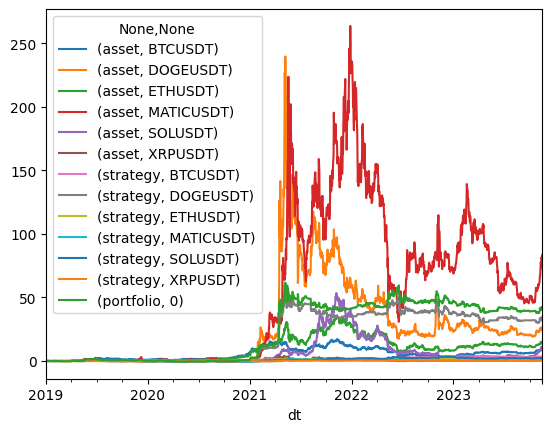

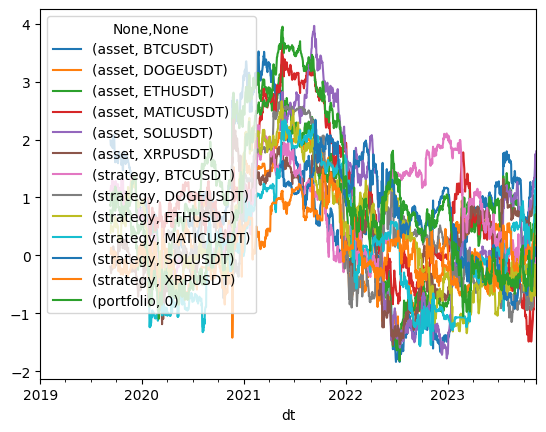

In [8]:
display(perf)
perf_cum.plot()
perf_sr.plot()

,annual_sharpe,annual_volatility,cagr,max_drawdown,profit_cost_ratio
portfolio,1.179668,1.441358,1.196472,0.924285,8.253758


<Axes: xlabel='dt'>

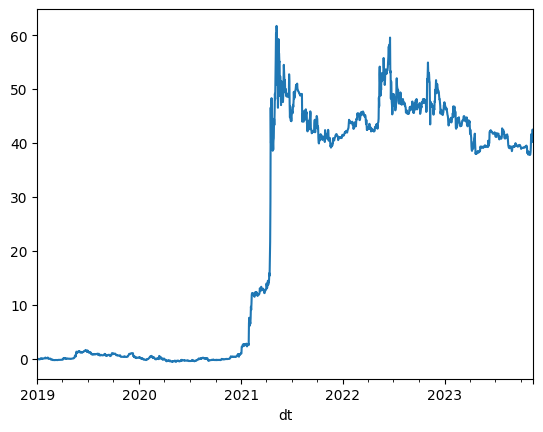

In [9]:
display(port_perf)
port_cum.plot()